<a href="https://colab.research.google.com/github/infox182/NN-Twitter/blob/master/bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сентимент анализ сообщений Twitter

In [0]:
import pandas as pd
import numpy as np
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import twitter_samples, stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk import FreqDist, classify, NaiveBayesClassifier
from sklearn.feature_extraction.text import CountVectorizer
import re, string, random

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# file = 'eng_data.xlsx'
file = '/content/drive/My Drive/Colab Notebooks/Sentyment/eng_data.xlsx'
data = pd.ExcelFile(file).parse()

In [0]:
data.head()

,tweet,sentiment
0,#stl we war ready #ripmikebrown #ferguson http...,2
1,one of the best moments from ystrdy was when a...,2
2,public art. canfield. photo. #ferguson http://...,3
3,canfield. public art cont. #ferguson http://if...,3
4,public art exhibit. canfield. #ferguson http:/...,3


In [0]:
data.shape

(1205, 2)

In [0]:
data.describe()

,sentiment
count,1205.000000
mean,2.378423
std,0.742313
min,1.000000
25%,2.000000
50%,3.000000
75%,3.000000
max,3.000000


In [0]:
tweets = list(data['tweet'])

In [0]:
y = list(data['sentiment'])

In [0]:
def remove_noise(tweet_tokens, stop_words = ()):
    cleaned_tokens = []
    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)

        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)
        if token != '':
            if token[0] == '#':
                token = token[1:]
        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words\
                                                                and token.count('pic.twitter') == 0:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

def clean_review(review):
      
    review = re.sub("[^A-Za-z]", " ", review)
    review = review.lower()
    review = word_tokenize(review)
    stemmer = PorterStemmer()
    review = [stemmer.stem(word) for word in review if word not in set(stopwords.words("english"))]
    review = " ".join(review)
    return review

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
stop_words = stopwords.words('english')

In [0]:
from nltk.tokenize import casual_tokenize
tokens_tweets = []
for tweet in tweets:
        tokens_tweets.append(casual_tokenize(tweet))

In [0]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
clean_token_tweets = []
for token in tokens_tweets:
        clean_token_tweets.append(remove_noise(token, stop_words))

In [0]:
clean_token_tweets[0]

['stl', 'war', 'ready', 'ripmikebrown', 'ferguson']

In [0]:
def joinmy(review):
    review = " ".join(review)
    return review
clean_token_tweets_predl = [joinmy(i) for i in clean_token_tweets ]

In [0]:
data['tweet_for_nn'] = clean_token_tweets_predl

In [0]:
def to_sentiment(rating):
  rating = int(rating)
  rating -= 1
  return rating

In [0]:
data['sentiment'] = data.sentiment.apply(to_sentiment)

In [0]:
del data['tweet']

In [0]:
data.columns = ['tweet_for_nn','sentiment']

## Тест модуль

In [0]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix as conf_matr
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

def score_test(y_true,y_pred):#на вход истинные метки и предсказанные
    
    cm = conf_matr(y_true,y_pred) #обычная
    cmn = conf_matr(y_true,y_pred,normalize ='true') #нормированная
    class_names = ['positive','negative','neutral']

    #строим графики
    for matr in [cm,cmn]:
        disp = ConfusionMatrixDisplay(confusion_matrix=matr,display_labels=class_names)
        disp = disp.plot(cmap=plt.cm.Blues)

    plt.show()
    print(cm,'\n','\n',cmn,'\n')
    accuracy = accuracy_score(y_true,y_pred)
    f1 = f1_score(y_true,y_pred,average = 'weighted')
    print(f'accuracy = {accuracy}')
    print(f'F1 score = {f1}')

## Обучение нейронками

### BERT

In [0]:
!pip install -qq transformers

In [0]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [0]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [0]:
token_lens = []
for txt in data.tweet_for_nn:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

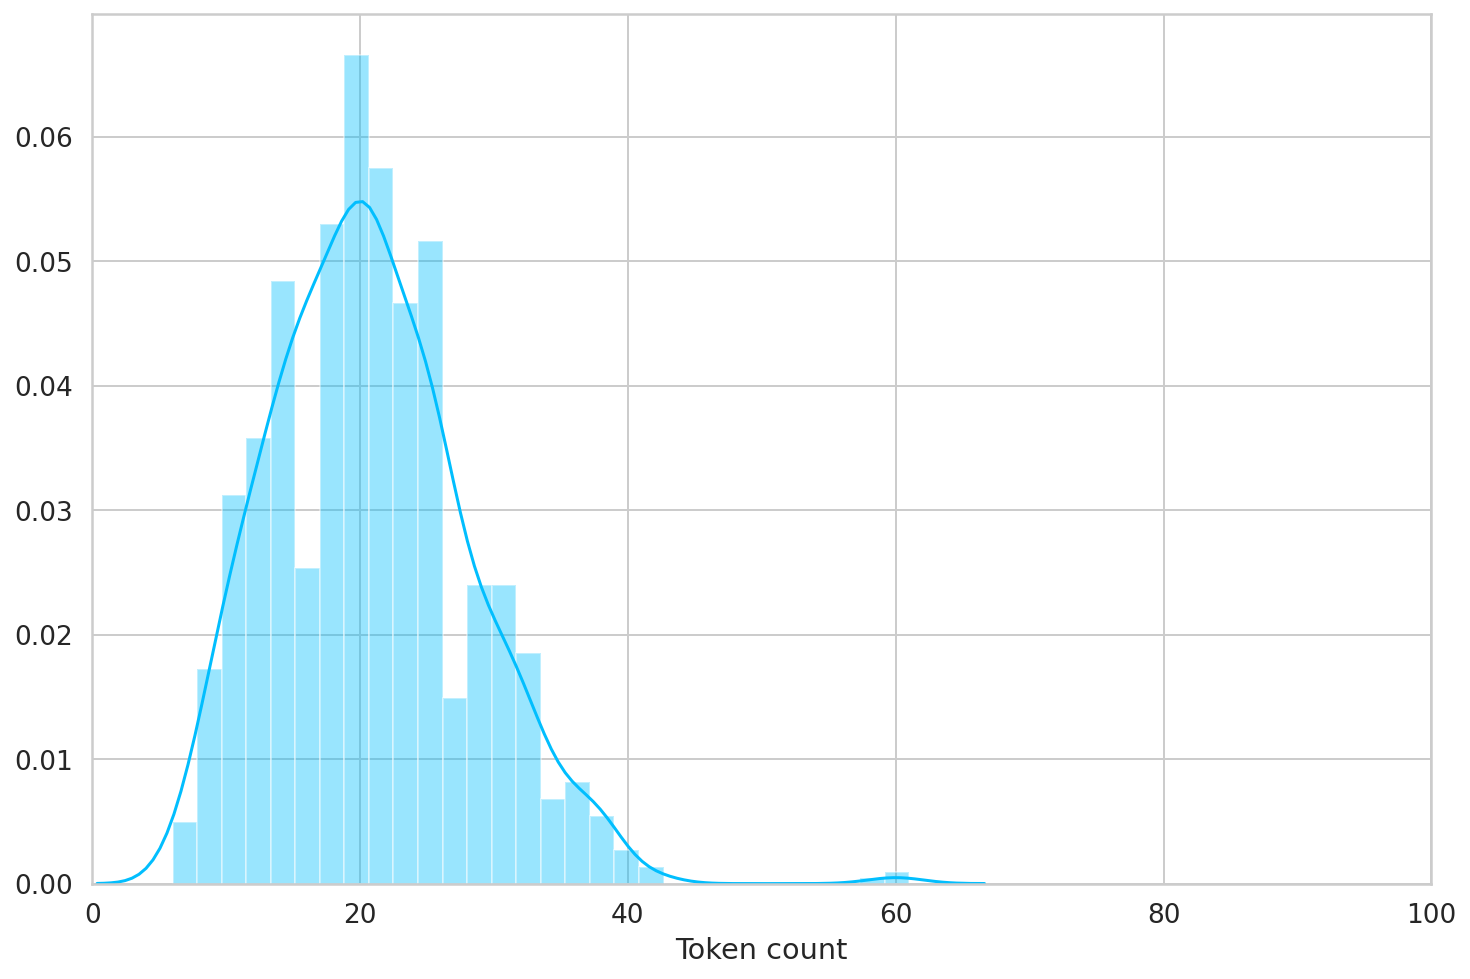

In [0]:
sns.distplot(token_lens)
plt.xlim([0, 100])
plt.xlabel('Token count');

In [0]:
MAX_LEN = 65

In [0]:
class MakeTweetDataset(Dataset):
  def __init__(self, tweets, targets, tokenizer, max_len):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.tweets)
  def __getitem__(self, item):
    tweet= str(self.tweets[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [0]:
df_train, df_test = train_test_split(
  data,
  test_size=0.15,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [0]:
df_train.shape, df_val.shape, df_test.shape

((1024, 2), (90, 2), (91, 2))

In [0]:
def create_data_loader(data, tokenizer, max_len, batch_size):
  ds = MakeTweetDataset(
    tweets=data.tweet_for_nn.to_numpy(),
    targets=data.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [0]:
BATCH_SIZE = 8

In [0]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [0]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [0]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    return self.out(output)

In [0]:
model = SentimentClassifier(3)

In [0]:
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [0]:
for param in model.parameters():
    param.requires_grad = False
for param in model.bert.encoder.layer[8:12].parameters():
    param.requires_grad = True
for param in model.bert.pooler.parameters():
    param.requires_grad = True
for param in model.out.parameters():
    param.requires_grad = True

In [0]:
params_to_update = model.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 bert.encoder.layer.8.attention.self.query.weight
	 bert.encoder.layer.8.attention.self.query.bias
	 bert.encoder.layer.8.attention.self.key.weight
	 bert.encoder.layer.8.attention.self.key.bias
	 bert.encoder.layer.8.attention.self.value.weight
	 bert.encoder.layer.8.attention.self.value.bias
	 bert.encoder.layer.8.attention.output.dense.weight
	 bert.encoder.layer.8.attention.output.dense.bias
	 bert.encoder.layer.8.attention.output.LayerNorm.weight
	 bert.encoder.layer.8.attention.output.LayerNorm.bias
	 bert.encoder.layer.8.intermediate.dense.weight
	 bert.encoder.layer.8.intermediate.dense.bias
	 bert.encoder.layer.8.output.dense.weight
	 bert.encoder.layer.8.output.dense.bias
	 bert.encoder.layer.8.output.LayerNorm.weight
	 bert.encoder.layer.8.output.LayerNorm.bias
	 bert.encoder.layer.9.attention.self.query.weight
	 bert.encoder.layer.9.attention.self.query.bias
	 bert.encoder.layer.9.attention.self.key.weight
	 bert.encoder.layer.9.attention.self.key.bias
	 b

In [0]:
model = model.to(device)

In [0]:
EPOCHS = 15
optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [0]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in tqdm(data_loader):
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [0]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  predictions = []
  real_labels = []
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

      predictions += (list(np.array(preds)))
      real_labels += (list(np.array(targets)))
  return correct_predictions.double() / n_examples, np.mean(losses), predictions, real_labels

In [0]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in tqdm(range(EPOCHS)):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss, _, _ = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/Sentyment/best_model_state.bin')
    best_accuracy = val_acc

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [0]:
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/Sentyment/best_model_state.bin'))

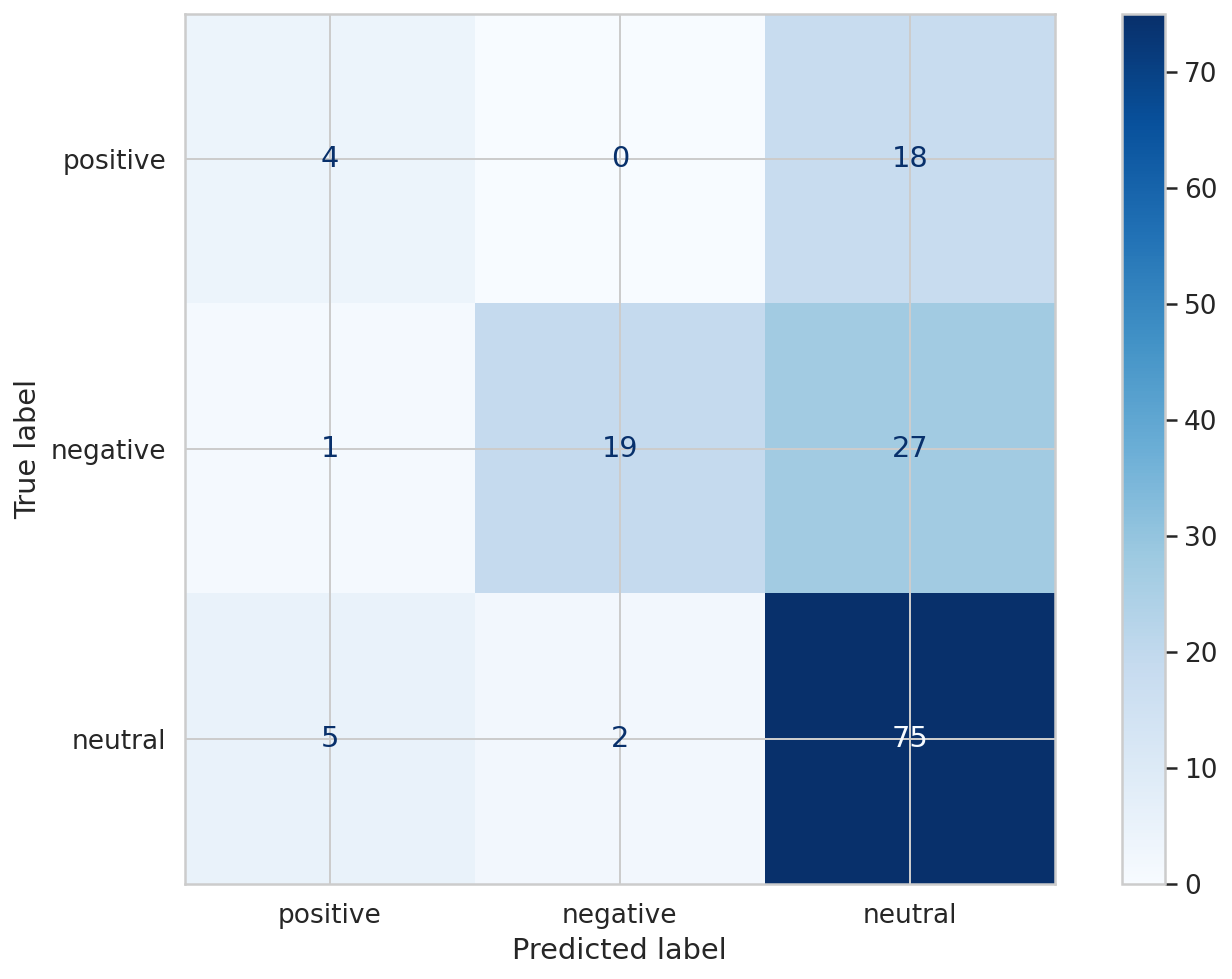

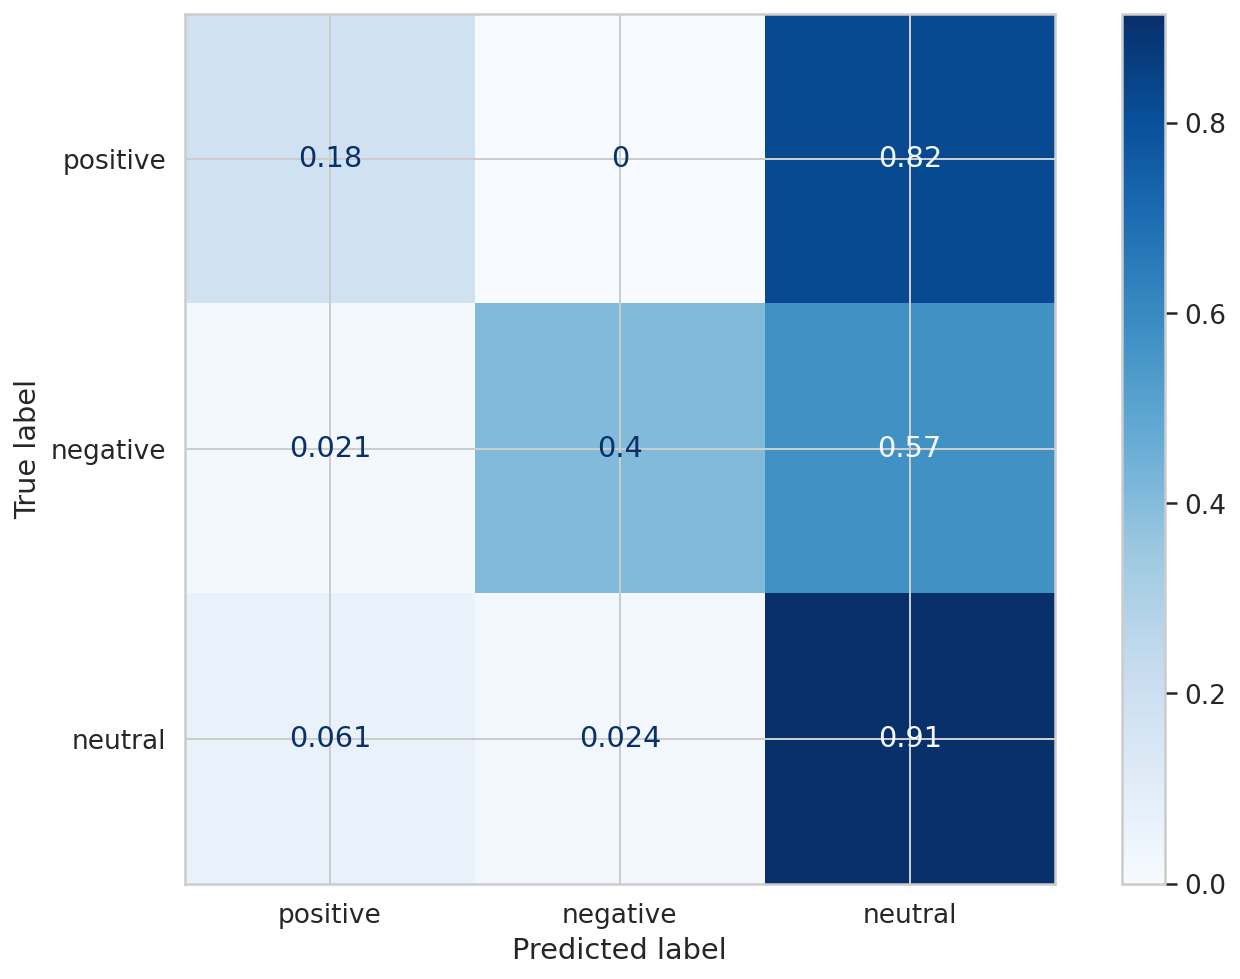

[[ 4  0 18]
 [ 1 19 27]
 [ 5  2 75]] 
 
 [[0.18181818 0.         0.81818182]
 [0.0212766  0.40425532 0.57446809]
 [0.06097561 0.02439024 0.91463415]] 

accuracy = 0.6490066225165563
F1 score = 0.6136145363659856


In [0]:
#20 эпох полностьобучался bert
pred_neur,real_labels = eval_model(model, test_data_loader, loss_fn, device, 3)
score_test(real_labels,pred_neur)

Epoch 1/15
----------



Train loss 0.9426190566737205 accuracy 0.55859375
Val   loss 0.7873712380727133 accuracy 0.6444444444444445

Epoch 2/15
----------



Train loss 0.7309533697552979 accuracy 0.6943359375
Val   loss 0.7439817016323408 accuracy 0.6777777777777778

Epoch 3/15
----------



Train loss 0.500734566594474 accuracy 0.818359375
Val   loss 0.7949469635883967 accuracy 0.7111111111111111

Epoch 4/15
----------



Train loss 0.2896052029391285 accuracy 0.9091796875
Val   loss 0.8913261294364929 accuracy 0.7444444444444445

Epoch 5/15
----------



Train loss 0.19100198263640777 accuracy 0.953125
Val   loss 1.1902831237142284 accuracy 0.7222222222222222

Epoch 6/15
----------



Train loss 0.13974074846373696 accuracy 0.9658203125
Val   loss 1.39160326992472 accuracy 0.7444444444444445

Epoch 7/15
----------



Train loss 0.08728965308955594 accuracy 0.9775390625
Val   loss 1.27416871363918 accuracy 0.7333333333333333

Epoch 8/15
----------



Train loss 0.045514431673382205 accuracy 0.9853515625
Val   loss 1.4161226282206674 accuracy 0.7666666666666667

Epoch 9/15
----------



Train loss 0.03448849368135143 accuracy 0.9912109375
Val   loss 1.4420741979653637 accuracy 0.7777777777777778

Epoch 10/15
----------



Train loss 0.021933384434703385 accuracy 0.9921875
Val   loss 1.5609879568219185 accuracy 0.7777777777777778

Epoch 11/15
----------



Train loss 0.015425211520607718 accuracy 0.99609375
Val   loss 1.5263911299407482 accuracy 0.7777777777777778

Epoch 12/15
----------



Train loss 0.010685256195415604 accuracy 0.99609375
Val   loss 1.4516781501006335 accuracy 0.8

Epoch 13/15
----------



Train loss 0.013457749813198916 accuracy 0.9970703125
Val   loss 1.4509453530578564 accuracy 0.7777777777777778

Epoch 14/15
----------



Train loss 0.015606029739785754 accuracy 0.9970703125
Val   loss 1.496485657369097 accuracy 0.7777777777777778

Epoch 15/15
----------



Train loss 0.0071264210446884135 accuracy 0.9970703125
Val   loss 1.4782678380918999 accuracy 0.7777777777777778


CPU times: user 1h 33min 52s, sys: 6min 22s, total: 1h 40min 14s
Wall time: 1h 40min 44s


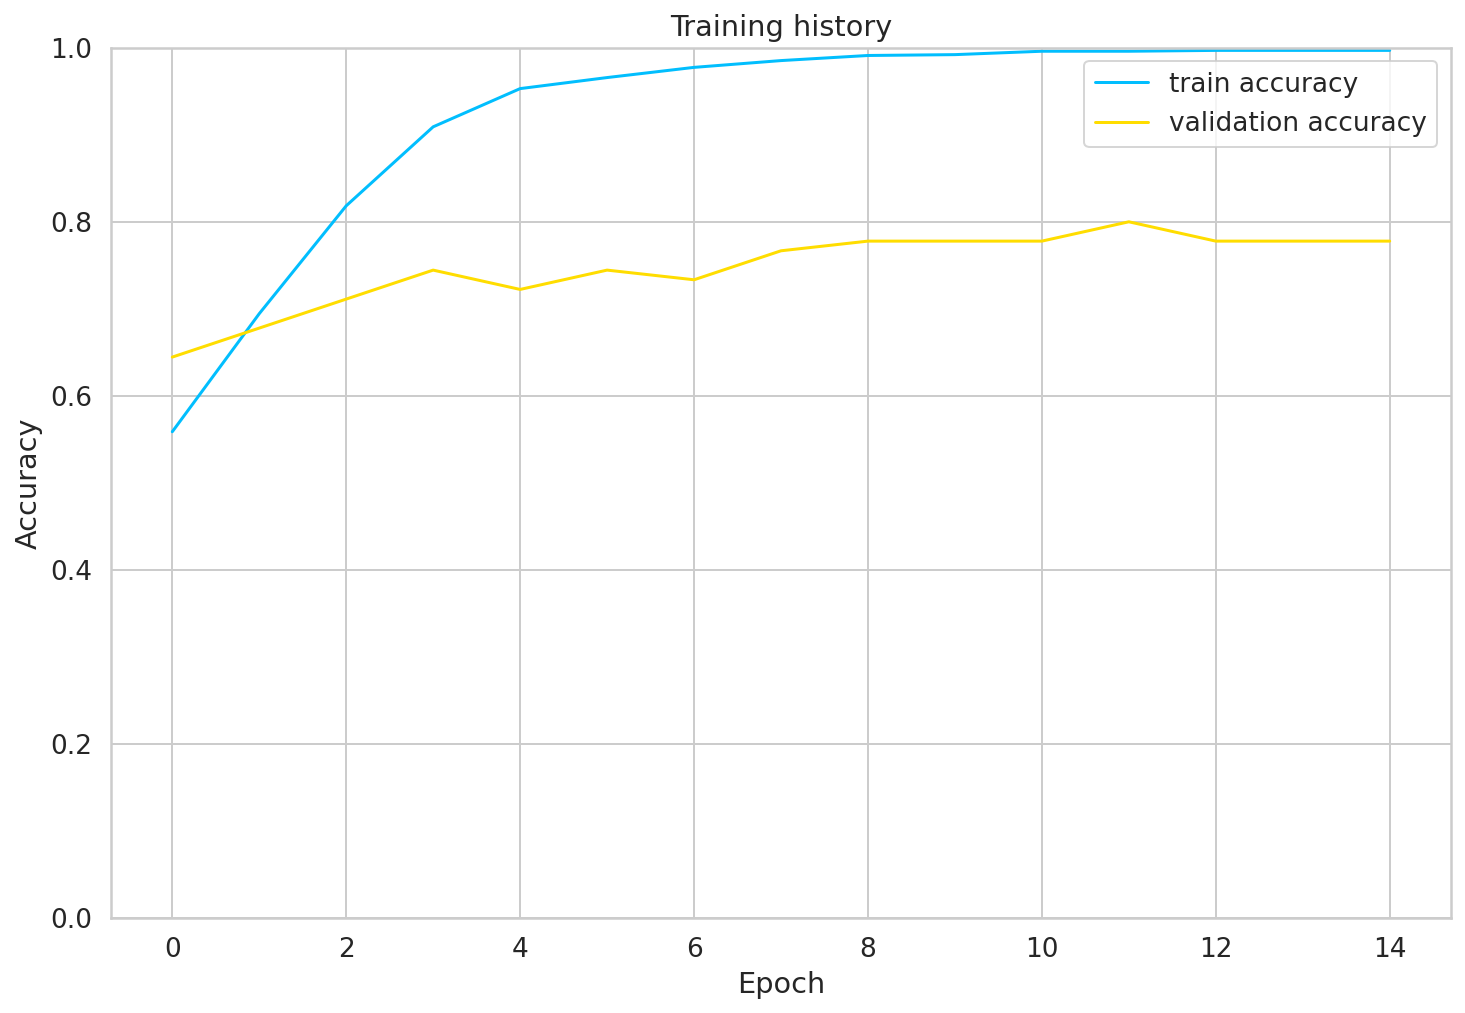

In [0]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in tqdm(range(EPOCHS)):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss, _, _ = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/Sentyment/dirty.bin')
    best_accuracy = val_acc

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

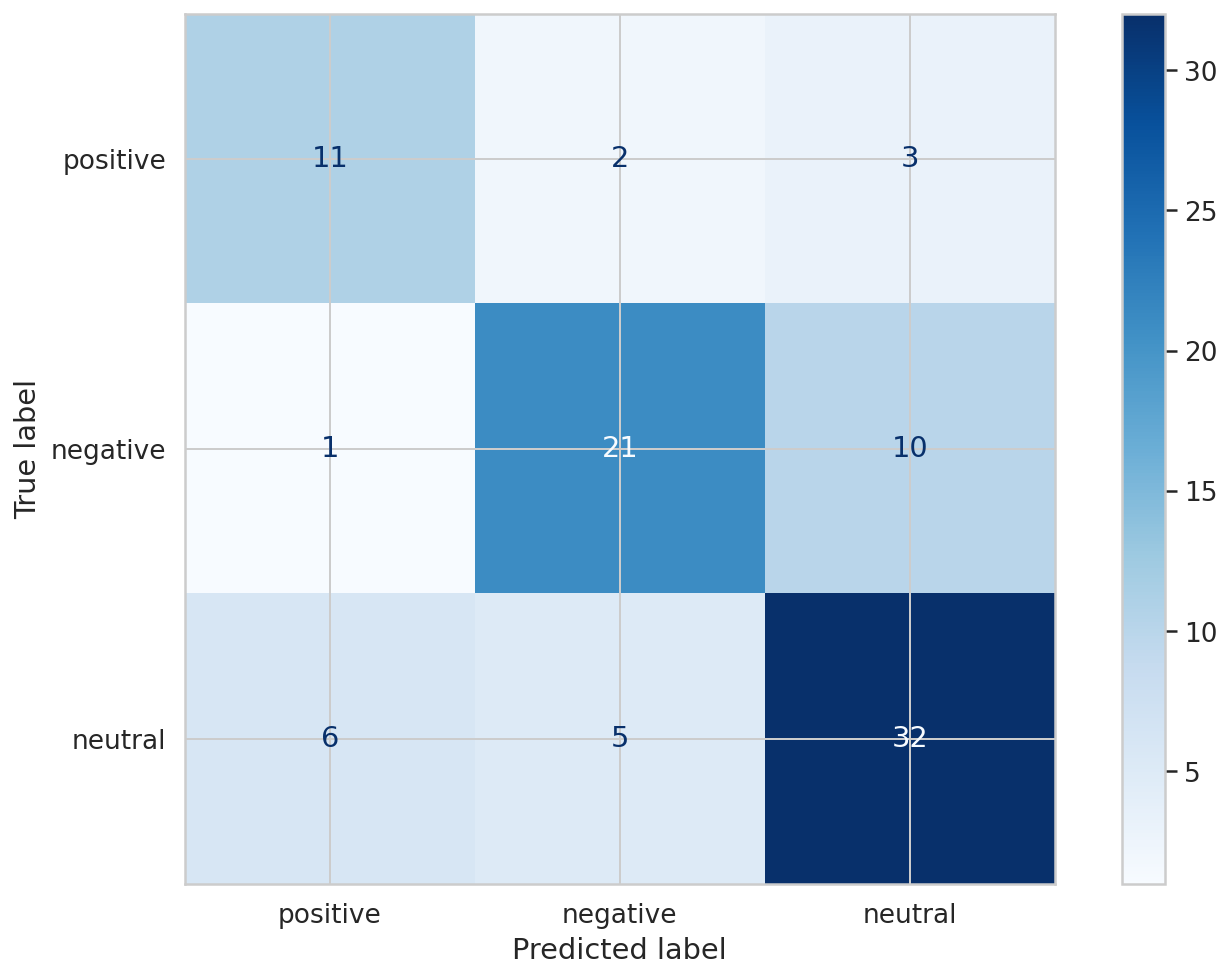

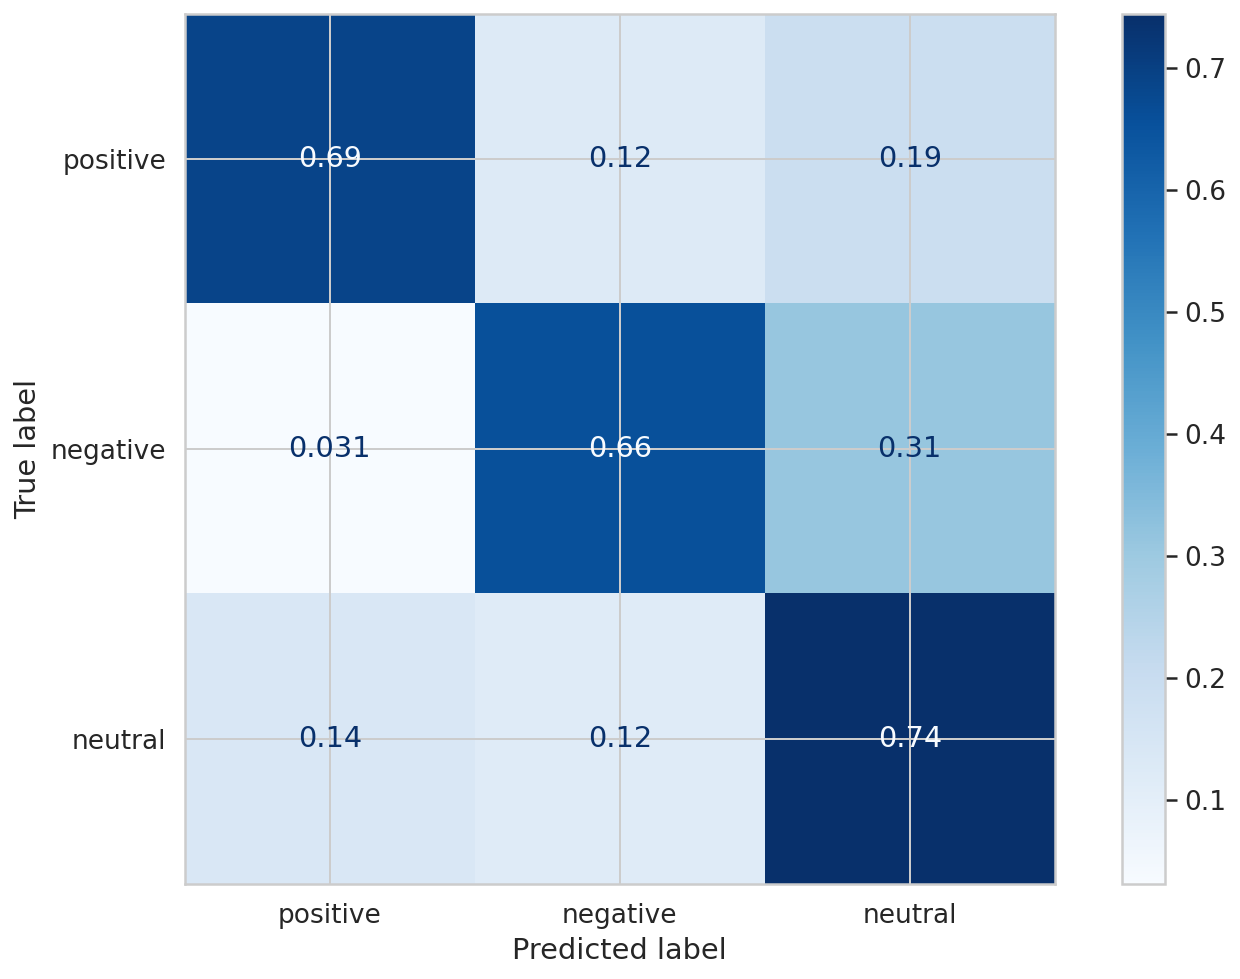

[[11  2  3]
 [ 1 21 10]
 [ 6  5 32]] 
 
 [[0.6875     0.125      0.1875    ]
 [0.03125    0.65625    0.3125    ]
 [0.13953488 0.11627907 0.74418605]] 

accuracy = 0.7032967032967034
F1 score = 0.7035787741670095


In [0]:
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/Sentyment/dirty.bin'))
_,_,pred_neur,real_labels = eval_model(model, test_data_loader, loss_fn, device, 3)
score_test(real_labels,pred_neur)